Try to extract coordinates from tables

In [167]:
import json
from pathlib import Path
from ontology_learner.publication import Publication
from tqdm import tqdm
from llm_query.chat_client import ChatClientFactory
from dotenv import load_dotenv
import os
from ontology_learner.gpt4_direct.gpt_term_mining import (
    mk_batch_script,
    run_batch_request,
    wait_for_batch_completion,
    get_batch_results,
    save_batch_results,
    )
from ontology_learner.json_utils import get_jsonl_file, parse_jsonl_results, load_jsonl
import numpy as np
import pandas as pd
from icecream import ic
import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv()
api_key = os.getenv("OPENAI")

datadir = Path(os.getenv('DATADIR'))
print(datadir)

client = ChatClientFactory.create_client("openai", model="gpt-4o", 
                                         api_key=api_key,
                                         temperature=1.0)

jsondir = datadir / 'json'





/Users/poldrack/Dropbox/data/ontology-learner/data


In [2]:
jsonfiles = list(jsondir.glob('*.json'))
pmids = [f.stem for f in jsonfiles]
len(pmids)


132257

In [11]:
tabledata = {}

for pmid in tqdm(pmids):
    p = Publication(pmid, datadir=jsondir)
    p.parse_sections()
    if 'TABLE' in p.sections and 'coordinate' in p.sections['TABLE'].lower():
        tabledata[pmid] = p.sections['TABLE']



100%|██████████| 132257/132257 [00:49<00:00, 2667.42it/s]


In [12]:
print(len(tabledata))

14635


In [13]:
tabledata['3467966']

'MNI coordinates and response intensity of brain regions displaying a significant response to Animate > Random stimuli p < 0.05 (corrected). Anatomical region\tHem\tx\ty\tz\tZ\tk\t \tPosterior superior temporal sulcus\tR\t50\t-66\t-8\t8.65\t13,033\t \t\tL\t-48\t-74\t-8\t8.82\t5671\t \tPrecentral gyrus\tR\t48\t8\t34\t6.21\t4976\t \tInferior frontal gyrus (BA 45)\tL\t-50\t26\t14\t5.57\t2610\t \tDorsomedial prefrontal cortex\t-\t2\t62\t22\t4.52\t1365\t \tAnterior intraparietal sulcus\tL\t-38\t-38\t44\t4.74\t1307\t \t Note: MNI coordinates are reported. Hem, hemisphere; L, left; R, right; Z, z-statistic; k, cluster size (in voxels). MNI coordinates and response intensity of cluster peaks identified in which brain response for the Animate > Random contrast varied significantly as a function of OXTR methylation p < 0.05 (corrected). Anatomical region\tHem\tx\ty\tz\tZ\tk\t \tSuperior temporal gyrus/supramarginal gyrus\tL\t-64\t-24\t12\t4.20\t713\t \tDorsal anterior cingulate cortex\tR\t12\t6\

In [14]:
def get_coord_prompt(table_data):
    return f"""
The following text contains the data from a table in a published research paper that uses 
functional MRI brain imaging.  The table contains coordinates of brain activation, 
listed as X/Y/Z locations, as well as labels for the anatomical location of those regions.  
Please extract the locations (which should be numbers in the range of -150 to 150) and labels.  If possible, 
please also extract the type of statistic being reported (e.g. t, z), the value of the statistic 
(which should be a number), the cluster size, and the type of coordinate (e.g., MNI, Talairach).  

There may be multiple tables that contain information about different comparisons between
conditions, known as contrasts (e.g. "Incongruent > Congruent"). 
If there are multiple tables for different contrasts, please return a list of dictionaries, 
one for each table.


## TABLE DATA ##
{table_data}

## RESPONSE ##

You should return the new list as a JSON dictionary, with no additional text. If there are
no coordinates present in the table, return an empty list.

Each table should include a list of dictionaries with the following contents, using the name of the 
contrast (e.g. "Incongruent > Congruent") as the key for each table dictionary:

The output should include list of dictionaries for each coordinate in the table, each containing the following keys:
    - contrast: the name of the contrast (e.g. "Incongruent > Congruent")
    - x: the x coordinate
    - y: the y coordinate
    - z: the z coordinate
    - cluster_size: the size of the cluster
    - label: the label for the anatomical location
    - statistic: the statistic being reported (e.g. t, z)
    - coordinate_type: the type of coordinate (e.g. MNI, Talairach)
    
"""

# resp = client.chat(get_coord_prompt(tabledata['3467966']))

In [19]:

coordinate_mining_dir = datadir / 'coordinate_extraction/gpt4_results'
coordinate_mining_dir.mkdir(exist_ok=True, parents=True)

batchfile = datadir / 'coordinate_extraction/gpt4_coordinate_extraction_batch.jsonl'
custom_ids = list(tabledata.keys())
tabledata_list = [tabledata[pmid] for pmid in custom_ids]

if len(list(coordinate_mining_dir.glob('*.jsonl'))) == 0:
    #mk_batch_script(batchfile, tabledata_list, get_coord_prompt, custom_ids=custom_ids)
    #batch_metadata, batch_client = run_batch_request(batchfile, 'coordinate_extraction')

    #wait_for_batch_completion(batch_metadata, batch_client)
    batch_results = get_batch_results(batch_client, batch_metadata.id)
    outfile = save_batch_results(batch_results, batch_metadata.id, coordinate_mining_dir)

In [28]:

coordinate_mining_file = get_jsonl_file(coordinate_mining_dir)
coord_results = parse_jsonl_results(load_jsonl(coordinate_mining_file))

with open(datadir / 'coordinate_extraction/coord_results_gpt4.json', 'w') as f:
    json.dump(coord_results, f, indent=4)


error decoding 6417219
error decoding 3632522
error decoding 3897558
error decoding 7274441
error decoding 9421497
error decoding 9441296
error decoding 5390729
error decoding 8318202
error decoding 2769569
error decoding 8113515
error decoding 4477185
error decoding 7462432
error decoding 5079119
error decoding 10262285
error decoding 6392062
error decoding 5529460
error decoding 2784027
error decoding 3500241
error decoding 3715724
error decoding 5385589
error decoding 7455219
error decoding 6214971
error decoding 8566670
error decoding 3385211
error decoding 2742320
error decoding 5963950
error decoding 5002375
error decoding 9799965
error decoding 4429863
error decoding 4055615
error decoding 3909704
error decoding 3853419
error decoding 3592389
error decoding 3543395
error decoding 7998905
error decoding 6777552
error decoding 9059616
error decoding 3439853
error decoding 6033386
error decoding 5724021
error decoding 8561439
error decoding 7670650
error decoding 4182671
error deco

### Process extracted coordinates

In [35]:
coord_results_clean = {k: v for k, v in coord_results.items() if len(v) > 0}
print(f'found {len(coord_results_clean)} tables with coordinates in {len(coord_results)} tables')



found 10460 tables with coordinates in 11034 tables


In [135]:
def is_good_coord(coord):
    return 'x' in coord and 'y' in coord and 'z' in coord

def parse_coord_dict(coord_result, verbose=True):
    if 'contrast' in coord_result:
        coord_result = {coord_result['contrast']: coord_result}

    if verbose:
        print(f'found {len(coord_result)} contrasts')
    for contrast, tab in coord_result.items():
        if verbose:
            ic(tab)
            ic(f'found {len(tab["coordinates"])} coordinates in {contrast}')
        for coord in tab['coordinates']:
            good_coord = 'good coord' if is_good_coord(coord) else 'bad coord'
            if verbose:
                ic(f'{good_coord}: {coord}')
    return coord_result


def parse_coord_result(coord_result, verbose=True):
    if isinstance(coord_result, dict):
        clean_coord_result = parse_coord_dict(coord_result, verbose)
    elif isinstance(coord_result, list):
        clean_coord_result = {}
        for item in coord_result:
            clean_coord_result.update(parse_coord_dict(item, verbose))
    else:
        print(f'skipping {coord_result} because it is a {type(coord_result)}')

    return clean_coord_result

k = '4468026' #list(coord_results_clean.keys())[0]
parse_coord_result(coord_results_clean[k], verbose=False)

{'Paralimbic cytology compared to BNC': {'coordinates': [{'x': -6,
    'y': -34,
    'z': 40,
    'cluster_size': None,
    'label': 'L. PCC dysgranular',
    'statistic': None,
    'coordinate_type': 'MNI'},
   {'x': -6,
    'y': -52,
    'z': 25,
    'cluster_size': None,
    'label': 'L. PCC granular',
    'statistic': 'Z = -2.62 (+-0.2)',
    'coordinate_type': 'MNI'},
   {'x': 6,
    'y': -34,
    'z': 40,
    'cluster_size': None,
    'label': 'R. PCC dysgranular',
    'statistic': None,
    'coordinate_type': 'MNI'},
   {'x': 6,
    'y': -52,
    'z': 25,
    'cluster_size': None,
    'label': 'R. PCC granular',
    'statistic': 'Z = -2.48 (+-0.2)',
    'coordinate_type': 'MNI'},
   {'x': -6,
    'y': 38,
    'z': 10,
    'cluster_size': None,
    'label': 'L. pACC agranular',
    'statistic': None,
    'coordinate_type': 'MNI'},
   {'x': -6,
    'y': 56,
    'z': 10,
    'cluster_size': None,
    'label': 'L. pACC granular',
    'statistic': 'Z = 0.03 (+-0.2)',
    'coordinate_

In [136]:
bad_results = []
good_coord_results = {}
for k in list(coord_results_clean.keys()):
    try:
        good_coord_results[k] = parse_coord_result(coord_results_clean[k], verbose=False)
    except Exception as e:
        bad_results.append(k)

print(f'found {len(bad_results)} bad results in {len(coord_results_clean)} tables')




found 508 bad results in 10460 tables


### convert to a single coordinate list

In [151]:
coords_list = []

for k, v in good_coord_results.items():
    for contrast, contrast_dict in v.items():
        for coord in contrast_dict['coordinates']:
            x = coord['x'] if 'x' in coord else None
            y = coord['y'] if 'y' in coord else None
            z = coord['z'] if 'z' in coord else None
            cluster_size = coord['cluster_size'] if 'cluster_size' in coord else None
            label = coord['label'] if 'label' in coord else None
            statistic = coord['statistic'] if 'statistic' in coord else None
            coordinate_type = coord['coordinate_type'] if 'coordinate_type' in coord else None
            coords_list.append({
                'pmid': k,
                'contrast': contrast,
                'x': x,
                'y': y,
                'z': z,
                'cluster_size': cluster_size,
                'label': label,
                'statistic': statistic,
                'coordinate_type': coordinate_type
            })



In [150]:
coord

{'cluster_size': 1338,
 'label': 'Superior and inferior parietal gyrus, middle occipital gyrus, angular gyrus',
 'statistic': 't = 5.74',
 'coordinate_type': 'MNI'}

In [195]:
coords_df = pd.DataFrame(coords_list)
full_length = len(coords_df)
# remove rows with missing x/y/z coords
coords_df = coords_df[coords_df['x'].notna() & coords_df['y'].notna() & coords_df['z'].notna()]

# remove rows with x/y/z as lists
coords_df = coords_df[~coords_df['x'].apply(lambda x: isinstance(x, list))]

# remove rows with x/y/z values that are not numbers
coords_df = coords_df[coords_df['x'].apply(lambda x: isinstance(x, (int, float)))]
coords_df = coords_df[coords_df['y'].apply(lambda x: isinstance(x, (int, float)))]
coords_df = coords_df[coords_df['z'].apply(lambda x: isinstance(x, (int, float)))]

# remove rows with x/y/z values that are outside of the range of -200 to 200
coords_df = coords_df[coords_df['x'].apply(lambda x: x >= -200 and x <= 200)]
coords_df = coords_df[coords_df['y'].apply(lambda x: x >= -200 and x <= 200)]
coords_df = coords_df[coords_df['z'].apply(lambda x: x >= -200 and x <= 200)]


print(f'cleaup removed {full_length - len(coords_df)} rows out of {full_length} ({len(coords_df)} rows remaining)')



cleaup removed 1792 rows out of 226854 (225062 rows remaining)


In [186]:
# how many have cluster size
print(f'{len(coords_df[coords_df["cluster_size"].notna()])} rows with cluster size')

# how many have coordinate type
print(f'{len(coords_df[coords_df["coordinate_type"].notna()])} rows with coordinate type')

# how many have statistic
print(f'{len(coords_df[coords_df["statistic"].notna()])} rows with statistic')

# how many have label
print(f'{len(coords_df[coords_df["label"].notna()])} rows with label')


157480 rows with cluster size
214560 rows with coordinate type
196062 rows with statistic
223351 rows with label


In [196]:
coords_df.statistic.value_counts()

statistic
z             3550
Z             2846
t             2377
T             1368
F              834
              ... 
T-val 3.94       1
T-val 3.47       1
T-val 4.56       1
T-val 3.39       1
BSR -5.08        1
Name: count, Length: 72957, dtype: int64

In [187]:
print(coords_df.coordinate_type.value_counts())




coordinate_type
MNI              167075
Talairach         35224
Unknown            2422
unknown            1722
Not specified      1152
                  ...  
BA44/45               1
BA 8                  1
BA 11                 1
BA 40                 1
BA 37                 1
Name: count, Length: 209, dtype: int64


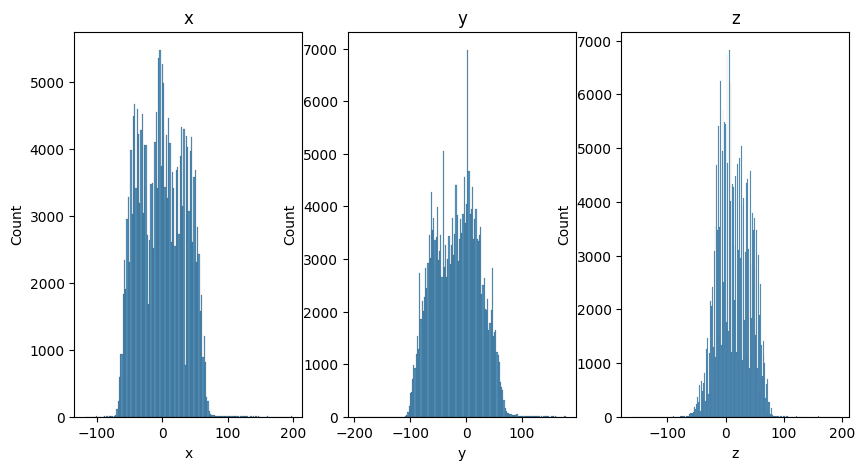

In [194]:
# plot x/y/z distributions as subplots in a single figure
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
sns.histplot(data=coords_df, x='x', ax=axs[0])
axs[0].set_title('x')
sns.histplot(data=coords_df, x='y', ax=axs[1])
axs[1].set_title('y')
sns.histplot(data=coords_df, x='z', ax=axs[2])
axs[2].set_title('z')
plt.show()




[[-7, 9]]

In [164]:
coords_df

,pmid,contrast,x,y,z,cluster_size,label,statistic,coordinate_type
0,7563784,TEA vs. TGA,-30,-30,-25,None,Parahippocampal gyrus (l),"{'t': 2.62, 'p': 0.499}",MNI
1,7563784,TEA vs. TGA,-20,-20,-20,None,Parahippocampal gyrus (l),"{'t': 3.05, 'p': 0.278}",MNI
2,7563784,TEA vs. TGA,-30,-5,-40,None,Uncus (l),"{'t': 3.83, 'p': 0.08}",MNI
3,7563784,TEA vs. TGA,-25,-5,-25,None,Uncus (l),"{'t': 3.83, 'p': 0.08}",MNI
4,7563784,TEA vs. TGA,-25,-20,-30,None,Parahippocampal gyrus (l),"{'t': 4.2, 'p': 0.042}",MNI
...,...,...,...,...,...,...,...,...,...
226849,3400659,Regions displaying greater activation during r...,18,-82,54,1405,"Lateral occipital cortex, supramarginal gyrus,...",3.63,MNI
226850,3400659,Regions displaying greater activation during r...,48,26,10,1112,"Inferior frontal gyrus, middle frontal gyrus, ...",3.67,MNI
226851,3400659,Regions displaying greater activation during r...,-48,14,4,939,"Inferior frontal gyrus, orbitofrontal cortex, ...",4.12,MNI
226852,3400659,Regions displaying greater activation during r...,6,38,42,815,"Superior frontal gyrus, supplementary motor co...",3.44,MNI
